In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
batch_size = 16
image_size = 28
num_channels = 1 # количество слоев
latent_layer = 100 # размер скрытого слоя

num_feats_gen = 32 # Количество фич в генераторе
num_feats_disc = 32 # Количество фич в дискриминаторе

num_epochs = 5
lr = 0.0002

beta1 = 0.5 #для оптимайзера Adam

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "data/mnist",
        train=True,
        download=False,
        transform=transforms.Compose(
            [transforms.Resize(image_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

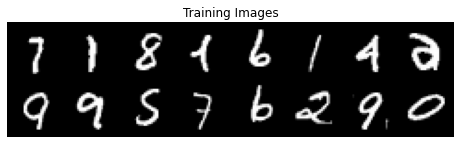

In [5]:
# Plot some training images
real_batch = next(iter(real_data))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Инициализация весов из нормального распределения с mean=0, stdev=0.02

In [6]:
# Функция для вывода и сохранения изображения
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

#### Генератор

In [74]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_layer, 64*7*7)
        self.conv1 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.batch1 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(64, 1, 4, 2, 1)
#         self.batch2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.ConvTranspose2d(32, num_channels, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(-1, 64, 7, 7)
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.relu(x)
        x = self.conv2(x)
#         x = self.batch2(x)
#         x = F.relu(x)
#         x = self.conv3(x)
        x = F.tanh(x)
        
        return x
        
        
#         self.main = nn.Sequential(
#             nn.Linear(latent_layer, 64*7*7),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 64, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(32, num_channels, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. 1 x 28 x 28

#         )

    

#### Дискриминатор

In [85]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, 3, 2, 1)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.batch2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*7*7, 1)
        
    def forward(self, x):
#         x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        
        return x
        
        
        
        
#         self.main = nn.Sequential(
#             # input is 1 x 28 x 28
#             nn.Conv2d(num_channels, 32, 3, 2, 1, bias=False),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. 32 x 14 x 14
#             nn.Conv2d(32, 64, 3, 2, 1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. 64 x 7 x 7
#             nn.Linear(64*7*7, 1),
#             nn.Sigmoid()
#         )

    

In [86]:
n_epochs = 150 # количество эпох
lr = 0.0002 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

latent_dim = 100 # Размерность случайного вектора, который подается на вход генератору


sample_interval = 25 # количество картинок для отображения процесса обучения

In [87]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [88]:
d_loss_history = []
g_loss_history = []

In [89]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_imgs = imgs.type(torch.FloatTensor).to(device)
        print('real_imgs', real_imgs.size())


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
#         z = torch.randn(64, latent_layer, 28, 28, device=device)
        print('z',  z.size())
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
        print('gen_imgs', gen_imgs.size())
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs).view(-1)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                sample_image(gen_imgs)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 


                display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
                plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
                plt.legend(handles=[red_patch, green_patch])
                plt.show()

            

real_imgs torch.Size([16, 1, 28, 28])
z torch.Size([16, 100])
gen_imgs torch.Size([16, 1, 28, 28])


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[16, 32, 14, 14] to have 1 channels, but got 32 channels instead

In [ ]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)
        
#         real_cpu = data[0].to(device)
#         b_size = real_cpu.size(0)
#         label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        real_imgs = imgs.to(device)
        print('real_imgs', real_imgs.size())
        
        # Прямой проход дисриминатора с реальными данными
        real_pred = discriminator(real_imgs)
        #Считаем потери на реальных данных
        d_real_loss = adversarial_loss(real_pred, valid)
        # Считаем градинт
        d_real_loss.backward()
        D_x = output.mean().item()
        

Процесс обучения:

In [ ]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, latent_layer, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(real_data, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device) 
        b_size = real_cpu.size(0) # 16
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
for i, data in enumerate(real_data, 0):
    print(data[0].size())